#### Get data from GDrive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### About Notebook
- Building Image Classifier Model from scratch.
- Verifying the Performance of the Model.
- Building Image Classifier Model Using Resnet by Transfer Learning.
- Tweak the Resnet by adding new layer and retrain only the BatchNorm layer of resnet
- Check the performance parameters of resnet based model.
- Compare the time taken by both the models.

### Importing Libraries

In [2]:
import torch
import torchvision
from torchvision import transforms, models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import numpy as np

import os
import copy
import time
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import sys


import matplotlib.pyplot as plt

#### Few Simple Augmentations like Horizontal Flip, Cropping are composed in Transformation Module of Torchvision

In [3]:
data_transforms = {
    'seg_train': transforms.Compose([
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'seg_test': transforms.Compose([
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

#### Things happening in Below cell
- Creating Data Loaders for both seg_train and seg_test.
- Applying Transforms while the dataloaders are created.
- Using GPU if available.
- Using Batch size of 16.
- Shuffling the deck of samples to avoid having continous deck of same sample with same class.

In [4]:
image_dataset_train_path = './gdrive/MyDrive/IntelImageClassification/seg_train/seg_train'
image_dataset_test_path = './gdrive/MyDrive/IntelImageClassification/seg_test/seg_test'

In [5]:
image_train = {x: torchvision.datasets.ImageFolder(image_dataset_train_path, data_transforms[x]) for x in ['seg_train']}
data_train = {x: torch.utils.data.DataLoader(image_train[x], batch_size=16,
                                              shuffle=True, num_workers=4) for x in ['seg_train']}

dataset_train = {x: len(image_train[x]) for x in ['seg_train']}
class_names = image_train['seg_train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
image_val = {x: torchvision.datasets.ImageFolder(image_dataset_test_path, data_transforms[x]) for x in ['seg_test']}
data_val = {x: torch.utils.data.DataLoader(image_val[x], batch_size=16,
                                              shuffle=True, num_workers=4) for x in ['seg_test']}

dataset_val = {x: len(image_val[x]) for x in ['seg_test']}

#### Building CNN
- 3 Conv Layers
- 4 Activation Unit - RELU
- 3 MaxPooling - Stride 2
- 2 FC Layers

In [8]:
class Img_clf(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 512, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*28*28, 64)
        self.fc2 = nn.Linear(64, 6)

    def forward(self, x):
        out = F.relu(F.max_pool2d(self.conv1(x),2))
        out = F.relu(F.max_pool2d(self.conv2(out),2))
        out = F.relu(F.max_pool2d(self.conv3(out),2))
        out = out.view(-1, 128*28*28)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

- Initializing the model.
- Moving to GPU if available.

In [9]:
model = Img_clf()
model.to(device) #Moving to Cuda if available

Img_clf(
  (conv1): Conv2d(3, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)

- Declaring the Loss Function
- Declaring the optimizer and passing the model parameters on which the optimization or weight updates needs to happen.

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

- Defining the Function train()
- Iterating through the Epochs
- Iterating through the Train and Validation Iterators.
- During each iteration, a batch of 16 sample is taken from both train and validation iterator. And each sample is a tuple of image - and label.
- In model.train() phase, it enables the parameters to learn.
- In model.eval() the parameters are disabled and the model is used only for making inferences.
- We are retaining the parameters, where the loss is minimum and accuracy is maximum.

In [11]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for data in [data_train, data_val]:
            phase = list(data.keys())[0]
            if phase == 'seg_train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'seg_train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'seg_train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'seg_train':
                epoch_loss = running_loss / dataset_train[phase]
                epoch_acc = running_corrects.double() / dataset_train[phase]
            else:
                epoch_loss = running_loss / dataset_val[phase]
                epoch_acc = running_corrects.double() / dataset_val[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'seg_test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

#### Training Model

In [12]:
trained_model = train_model(model, criterion, optimizer, num_epochs=5)

Epoch 0/4
----------
seg_train Loss: 1.1845 Acc: 0.5262
seg_test Loss: 0.9748 Acc: 0.6013

Epoch 1/4
----------
seg_train Loss: 0.9921 Acc: 0.6061
seg_test Loss: 0.8241 Acc: 0.6893

Epoch 2/4
----------
seg_train Loss: 0.8413 Acc: 0.6865
seg_test Loss: 0.6098 Acc: 0.7863

Epoch 3/4
----------
seg_train Loss: 0.8083 Acc: 0.7019
seg_test Loss: 0.5752 Acc: 0.7940

Epoch 4/4
----------
seg_train Loss: 0.7578 Acc: 0.7176
seg_test Loss: 0.5572 Acc: 0.8010

Training complete in 41m 56s
Best val Acc: 0.801000


In [13]:
# Specify a path to save to
PATH = "trained_model.pt"

# Save
torch.save(trained_model.state_dict(), PATH)

#### Transfer Learning
- Pretrained Model - Resnet50
- Keeping all the trained parameters intact without retraining, keeping parameters = False except BatchNormalization's Parameters as True
- Adding New Full connection Layer using nn.Sequential
- Learning only the parameters of the new added FC layer
#### Why Transfer Learning
- Less Computation
- Trained Parameters
- Updating BatchNorm layer of Resnet
- Keeping requires_grad=False for all layers, except BatchNorm Layer.

In [14]:
transfer_model = models.resnet50(pretrained=True)
for name, param in transfer_model.named_parameters():
    if ('bn' not in name):
        param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 80.2MB/s]


#### Adding FC layers to Resnet along with dropout¶

In [15]:
transfer_model.fc = nn.Sequential(nn.Linear(transfer_model.fc.in_features, 500), nn.ReLU(), nn.Dropout(), nn.Linear(500, 6))

In [16]:
  ### Pretrained Model
optimizer = torch.optim.Adam(transfer_model.parameters(), lr=0.01)
transfer_model.to(device)
trained_tl_model = train_model(transfer_model, criterion, optimizer,
                               num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


seg_train Loss: 1.0703 Acc: 0.6727
seg_test Loss: 0.8011 Acc: 0.7797

Epoch 1/9
----------
seg_train Loss: 0.6811 Acc: 0.7639
seg_test Loss: 0.3528 Acc: 0.8747

Epoch 2/9
----------
seg_train Loss: 0.6102 Acc: 0.7904
seg_test Loss: 0.3246 Acc: 0.8887

Epoch 3/9
----------
seg_train Loss: 0.5975 Acc: 0.7935
seg_test Loss: 0.3161 Acc: 0.8867

Epoch 4/9
----------
seg_train Loss: 0.5888 Acc: 0.7936
seg_test Loss: 0.3350 Acc: 0.8897

Epoch 5/9
----------
seg_train Loss: 0.5610 Acc: 0.8077
seg_test Loss: 0.4208 Acc: 0.8593

Epoch 6/9
----------
seg_train Loss: 0.5743 Acc: 0.8048
seg_test Loss: 0.3284 Acc: 0.8900

Epoch 7/9
----------
seg_train Loss: 0.5526 Acc: 0.8108
seg_test Loss: 0.3043 Acc: 0.8980

Epoch 8/9
----------
seg_train Loss: 0.5263 Acc: 0.8169
seg_test Loss: 0.3237 Acc: 0.8920

Epoch 9/9
----------
seg_train Loss: 0.5162 Acc: 0.8177
seg_test Loss: 0.3035 Acc: 0.8970

Training complete in 20m 3s
Best val Acc: 0.898000


In [22]:
# Specify a path to save to
PATH = "transfer_model.pt"
# Save
torch.save(transfer_model.state_dict(), PATH)

In [42]:
# Input to the model
x = torch.randn(1, 3, 224, 224, requires_grad=True, device="cuda")
transfer_model.to(device)
torch_out = transfer_model(x)

In [41]:
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 66.3 MB/s eta 0:00:00


In [43]:
# Export the model
torch.onnx.export(transfer_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "transfer_model.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



#### Applying Transformation to pred images


In [17]:
data_test_transform = {
    'seg_pred': transforms.Compose([
         transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

#### Creating DataLoader for Pred Images


In [18]:
image_test = {x: torchvision.datasets.ImageFolder("./gdrive/MyDrive/IntelImageClassification/seg_pred", data_test_transform[x]) for x in ['seg_pred']}
data_test = {x: torch.utils.data.DataLoader(image_test[x], batch_size=8,
                                              shuffle=True, num_workers=4) for x in ['seg_pred']}

dataset_sizes = {x: len(image_test[x]) for x in ['seg_pred']}

#### Keeping model in Eval phase, while predicting. Since parameters are not updated,while performing inferences.


In [19]:
transfer_model.eval()   # Set model to evaluate mode
for inputs, labels in data_test["seg_pred"]:
    inputs = inputs.to(device)
    outputs = trained_tl_model(inputs)
    _, preds = torch.max(outputs, 1)
    print(preds)
    break

tensor([3, 5, 4, 1, 2, 0, 2, 2], device='cuda:0')


#### Prediction Using Classifier Model


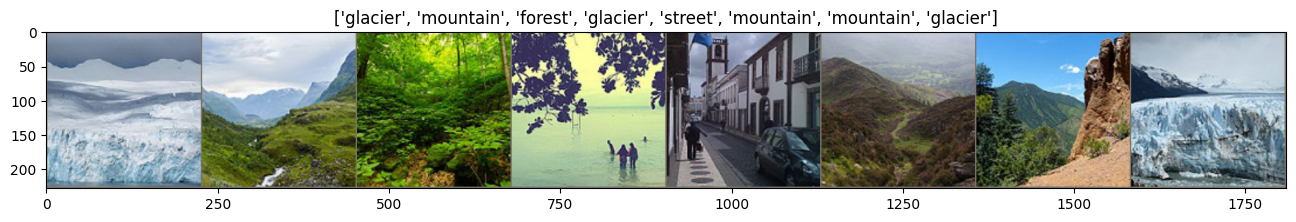

In [20]:
trained_model.to('cpu')
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(data_test['seg_pred']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#inputs = inputs#.to(device)
outputs = trained_model(inputs)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(16,16))
imshow(out, title=[class_names[x] for x in preds])

#### Prediction from Transfer Learning

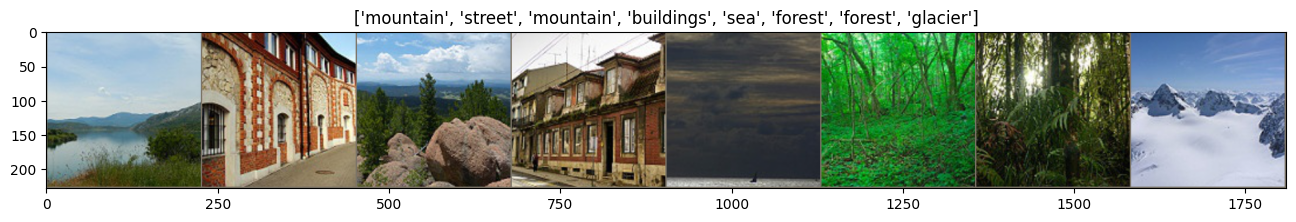

In [21]:
transfer_model.to('cpu')
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(data_test['seg_pred']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#inputs = inputs#.to(device)
outputs = trained_tl_model(inputs)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(16,16))
imshow(out, title=[class_names[x] for x in preds])